Ввод данных из файла

In [1]:
import collections as col
import itertools as it
import scipy.sparse as sparse
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math as m
import triangle as tr

In [2]:
# путь к файлу
f = open("newex1", "r")
all_file = f.readlines()
# Юнг, Пуассон
mu = float(all_file[0].split(' ')[0]) 
E = float(all_file[0].split(' ')[1])
# количество узлов
Num_nod = int(all_file[1])
#список узлов с координатами
Coord_nod = np.matrix([-1,-1])
for i in range(2,Num_nod + 2):
    this_line = all_file[i].split(' ')
    Coord_nod = np.append(Coord_nod,[[float(this_line[0]),float(this_line[1])]],axis = 0)
Coord_nod = np.delete(Coord_nod,0,axis = 0)
# количество конечных элементов
Num_el = int(all_file[Num_nod+2])
#список элементов с соответсвующими узлами
el_nod = np.matrix([-1,-1,-1])
for i in range(Num_nod+3,Num_nod+3+Num_el):
    this_line = all_file[i].split(' ')
    el_nod = np.append(el_nod,[[int(this_line[0]),int(this_line[1]),int(this_line[2])]],axis = 0)
el_nod = np.delete(el_nod,0,axis = 0)
print(type(el_nod))
# ограничения движения 
lim_in_nod = int(all_file[Num_nod+3+Num_el])
lim = np.matrix([-1,-1])
for i in range(Num_nod+4+Num_el,Num_nod+4+Num_el+lim_in_nod):
    this_line = all_file[i].split(' ')
    lim = np.append(lim,[[float(this_line[0]),float(this_line[1])]],axis = 0)
lim = np.delete(lim,0,axis = 0)
# количество узлов, в которых приложены усилия
eff_in_nod = int(all_file[Num_nod+4+Num_el+lim_in_nod])
eff = np.matrix([-1,-1,-1])
for i in range(Num_nod+5+Num_el+lim_in_nod,Num_nod+5+Num_el+lim_in_nod+eff_in_nod):
    this_line = all_file[i].split(' ')
    eff = np.append(eff,[[float(this_line[0]),float(this_line[1]),float(this_line[2])]],axis = 0)
eff = np.delete(eff,0,axis = 0)





<class 'numpy.matrix'>


In [3]:
# ищем матрицу D
D = E/(1 - mu*mu)*np.array([[1,mu,0],[mu,1,0],[0,0, (1-mu)/2]])
#D = E*(1-mu)/((1+mu)*(1-2*mu))*np.array([[1,mu/(1-mu),0],[mu/(1-mu),1,0],[0,0,(1-2*mu)/(2*(1-mu))]])
print(D)

[[2197.8021978   659.34065934    0.        ]
 [ 659.34065934 2197.8021978     0.        ]
 [   0.            0.          769.23076923]]


In [4]:
# убираем сингулярность
def K_ok(A,lim):
    print(lim)
    for i in range(len(lim)):
        for j in range(len(A)):
            if lim[i,0] == j:
                if lim[i,1] == 1:
                    ii = int(lim[i,0]*2)
                    for k in range(len(A)):
                        if j == k:
                            A[ii,j] = 1
                        else:
                            A[ii,j] = 0
                            A[j,ii] = 0
                if lim[i,1] == 2:
                    ii = int(lim[i,0]*2+1)
                    for k in range(len(A)):
                        if j == k:
                            A[ii,j] = 1
                        else:
                            A[ii,j] = 0
                            A[j,ii] = 0
                if lim[i,1] == 3:
                    ii1 = int(lim[i,0]*2)
                    ii0 = int(lim[i,0]*2+1)
                    
                    for k in range(len(A)):
                            A[ii1,k] = 0
                            A[k,ii1] = 0
                            A[ii0,k] = 0
                            A[k,ii0] = 0
                    A[ii1,ii1] = 1
                    A[ii0,ii0] = 1
    return A

In [5]:
#функция которой дают номера узлов, соответствующих элементу,
# и матрицу с координатами, а она считает определитель*2
def Det2(xi,yi,xj,yj,xk,yk):
    return (xj*(yk - yi) + xi*(yj - yk) + xk*(yi - yj))

In [6]:
def make_B(num,el_nod,Coord_nod,D,eff,lim):
    x,y,z = sp.symbols('x, y, z')
    ui,uj,uk = sp.var('ui uj uk')
    vi,vj,vk = sp.var('vi vj vk')
    wi,wj,wk = sp.var('wi wj wk')
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    # для конкретного элемента ищем координаты узлов
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]
    # пользуемся формулами со слайда 29
    Det = Det2(xi,yi,xj,yj,xk,yk)
    ai = (xj*yk - xk*yj)/Det
    aj = (xk*yi - xi*yk)/Det
    ak = (xi*yj - xj*yi)/Det
    bi = (yj - yk)/Det
    bj = (yk - yi)/Det
    bk = (yi - yj)/Det
    ci = (xk - xj)/Det
    cj = (xi - xk)/Det
    ck = (xj - xi)/Det
    
    # собираем матрицу B
    Bi =[[bi, 0],[0, ci],[ci, bi]]
    Bj =[[bj, 0],[0, cj],[cj, bj]] 
    Bk =[[bk, 0],[0, ck],[ck, bk]] 
    B0 = np.hstack([Bi, Bj, Bk])
    
    return B0

ВАЖНО!

In [7]:
def make_K(num,el_nod,Coord_nod,D,eff_final,lim):
    Bi = make_B(num,el_nod,Coord_nod,D,eff_final,lim)
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]

    return (Det2(xi,yi,xj,yj,xk,yk)/2)*Bi.T.dot(D).dot(Bi)

In [8]:
#make_K(0,el_nod,Coord_nod,D,eff) 

In [9]:
# глобальная K 
def sum_K(A,B,ind,num):
    a = len(A)
    b = len(B)
    for i in range(ind.shape[1]):
        for j in range(ind.shape[1]):
            ii = ind[0,i]
            jj = ind[0,j]
            A[ii*2:ii*2+2,jj*2:jj*2+2] += B[i*2:i*2+2,j*2:j*2+2]
    return A
        

с лентой я пока тоже ничего не делаю

In [10]:
# хранение полуленты
def band(A):
    n = len(A)
    B = np.zeros((n,6))
    A = np.block([A, np.zeros((n,5))])
    for i in range(n):
        B[i,:] = A[i,i:6+i]
    return B

In [11]:
# распаковка полуленты
def band_out(A):
    n = len(A)
    A = np.block([[A, np.zeros((n,n))]])
    B = np.zeros((n,n*2))
    for i in range(n):
        for j in range(n):
            B[i,i+j] = A[i,j]
            B[i,i-j] = B[i-j,i]
    
        
    return B[:,:n]

In [12]:
# генерируем вектор правых частей
def right(eff,num_nod):
    a = np.zeros(Num_nod*2)
    for i in range(len(eff)):
        for j in range(Num_nod):
            if eff[i,0] == j:
                a[j*2] = eff[i,1]
                a[j*2+1] = eff[i,2]
            
    return a

In [13]:
def FEM(el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim):
    rig = right(eff,Num_nod)
    K0 = np.zeros((Num_nod*2,Num_nod*2))
    for i in range(0,Num_el):
        ind = el_nod[i,:]
        K0 = sum_K(K0,make_K(i,el_nod,Coord_nod,D,eff,lim),ind[0],i)
    K0 = K_ok(K0,lim)

    U = np.linalg.solve(K0,rig.T)
    
    #достать перемещения можно где-то здесь
    max_sig = 0
    max_sig_i = -1
    m_s=0
    m_s_i=-1
    lnap = np.matrix([-1,-1,-1])
    for i in range(Num_el):
        B = make_B(i,el_nod,Coord_nod,D,eff,lim)
        Ui = np.zeros((6))
        Ui[0] = U[el_nod[i,0]*2]
        Ui[1] = U[el_nod[i,0]*2+1]
        Ui[2] = U[el_nod[i,1]*2]
        Ui[3] = U[el_nod[i,1]*2+1]  
        Ui[4] = U[el_nod[i,2]*2]
        Ui[5] = U[el_nod[i,2]*2+1] 
        #деформации (эпсилон)    
        Eps = B.dot(Ui)
        
        # напряжения(сигма)
        Nap = D.dot(Eps) 
        lnap = np.append(lnap,[[Nap[0],Nap[1],Nap[2]]],axis=0)
        NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]])
        
        Sig,s = np.linalg.eig(NapM) 
        
        now_sig = m.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
        
        if now_sig > max_sig:
            max_sig = now_sig
            max_sig_i = i
        
        #now_sig = max(abs(Sig))
        #if n_s > m_s:
         #   m_s = n_s
          #  m_s_i = i
        #print('Модуль максимального главного напряжения ',max(abs(Sig)))
        #print('Деформации в ',i,' элементе',Eps)
        #print('Напряжения в ',i,' элементе',Nap)
    print(max_sig)
    a = Coord_nod[el_nod[max_sig_i,0],:]
    b = Coord_nod[el_nod[max_sig_i,1],:]
    c = Coord_nod[el_nod[max_sig_i,2],:]
    
    for i in range(len(Coord_nod)):

        if Coord_nod[i,1]>=0: plt.plot(Coord_nod[i,0],Coord_nod[i,1],'b.')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(b[0,0],b[0,1],'r.')
    plt.plot(a[0,0],a[0,1],'r.')
    plt.plot(c[0,0],c[0,1],'r.')
    
    plt.axis('equal')
    print(a,b,c)
    lnap = np.delete(lnap,0,axis = 0)
    return U[100*2:120*2],lnap,U


In [14]:
f.close()

рассмотрим две подобласти для локального решения задачи: круглую и квадратную
как задавать их?
скорее всего, неравенствами

In [15]:
def circleLoc(o,r):
    ram = []
    coord = [0,0]
    for i in range(len(Coord_nod)):
        if m.sqrt((o[1] - Coord_nod[i,1])**2+(o[0] - Coord_nod[i,0])**2)<=r :
            
               
            plt.plot(Coord_nod[i,0],Coord_nod[i,1],'*b')
            
            coord = np.vstack([coord,Coord_nod[i,:]])
            ram = np.append(ram,i)
            print(i)
    coord = np.delete(coord,0,axis=0)
    return np.array(ram),np.array(coord)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


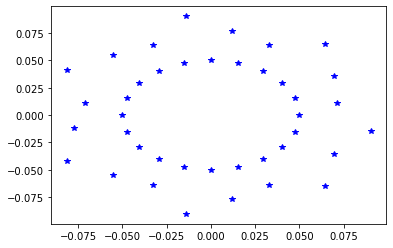

In [16]:
s,pts = circleLoc([0,0],0.1)

[]
28.951272710388775
[[0.03281103 0.06439527]] [[0.01545085 0.04755283]] [[0.02938926 0.04045085]]


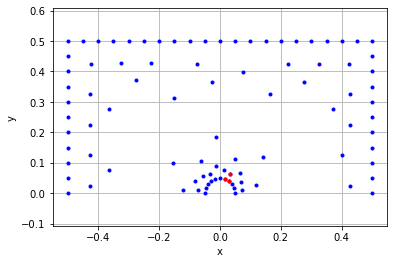

In [17]:
new_lim1,oldnap,finalU = FEM(el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim)
new_lim1= np.matrix(new_lim1)


делаем новую сетку


[[  3   2 113]]
[[114 113   2]]
[[  2   1 115]]
[[  2 115 114]]


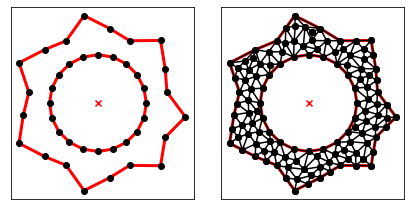

In [18]:

seg = np.vstack([np.array([[i,i+1] for i in range(19)]),[19,0],[20,26],[27,20],[26,33],[33,22],[22,29],[29,36],[36,23],[23,30],[30,37],[37,25],[25,32],[32,39],[39,31],[34,27],[34,21],[21,28],[28,35],[35,24],[38,31],[38,24]])
A = dict(vertices=pts,segments = seg,holes = [[0,0]])
B = tr.triangulate(A,'qpa0.0001')
tr.compare(plt, A, B)
#plt.xlim([-0.06,0.06])
#plt.ylim([-0.06,0.06])
#plt.grid()
#plt.xlabel('x')
#plt.ylabel('y')

#plt.show()
Coord_nod1 = np.matrix(B['vertices'])
Num_nod1 = len(B['vertices'])
el_nod1 = np.matrix(B['triangles'])

Num_el1 = len(B['triangles'])
for i in el_nod1:
    if np.any(i == 2): print(i)

In [19]:
def no0(M, k):
    n =  M.shape[0]
    while k < n and not M[k, k]:
        k += 1
    return k


In [20]:
def G(A,b):
        M = np.hstack((A, b)) # "склейка" матрицы коэффициентов при переменных и вектора свободных членов
        n = M.shape[0] 
        for k in range(n): 
            # убираем нули с главной диагонали, если они есть
            k0 = no0(M, k)
            if k0 != k:
                M[k0], M[k] = M[k].copy(), M[k0]   
            if M[k, k] != 1:
                M[k, :] *= 1 / M[k, k]
            # приямой ход метода Гаусса
            for r in range(k + 1, n):
                M[r, :] -= M[k, :] * M[r, k]
        #обратный ход метода Гаусса
        for k in range(n - 1, 0, -1):
            for r in range(k - 1, -1, -1):
                if M[r, k]:
                    M[r, :] -= M[k, :] * M[r, k]
        if b.shape[1] > 1:
            return np.hsplit(M,2)[1]
        return  (M[:,n])

In [21]:
# умножение матрицы на матрицу
def d(A,B):
    
    ans = np.zeros((A.shape[0],B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(B.shape[0]):
                ans[i,j] += A[i,k] * B[k,j]
    return ans

In [22]:
def null(A, eps=1e-15):
    u, s, vh = np.linalg.svd(A)
    null_space = np.compress(s <= eps, vh, axis=0)
    return null_space.T

In [25]:
def FEM1(el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim):

    K0 = np.zeros((Num_nod*2,Num_nod*2))
    for i in range(0,Num_el):
        ind = el_nod[i,:]
        K0 = sum_K(K0,make_K(i,el_nod,Coord_nod,D,eff,lim),ind[0],i)
    
    
    rig1 = np.vstack([np.zeros((40,1)),np.array(lim.T),np.zeros((246-80,1))])
    
    K1 = K0
    for j in range(len(rig1)):
        if rig1[j] != 0:
            for i in range(len(K0)):
                K0[j,i] = 0
            K0[j,j] = 1 
        
    rig = d(K1,rig1)
    
   # print(rig)
    #print(np.all(rig == rig1))
    #K0 = K_ok(K0,lim)
    #print(np.logical_or(sp.linsolve(K0,-rig)))
    U = null(K1)
    print(U)
    U = np.linalg.solve(K0,-rig)
    
   
    
    max_sig = 0
    max_sig_i = -1
    m_s=0
    m_s_i=-1
    print(Num_el)
    for i in range(Num_el):
        B = make_B(i,el_nod,Coord_nod,D,eff,lim)
        Ui = np.zeros((6))
        Ui[0] = U[el_nod[i,0]*2]
        Ui[1] = U[el_nod[i,0]*2+1]
        Ui[2] = U[el_nod[i,1]*2]
        Ui[3] = U[el_nod[i,1]*2+1]  
        Ui[4] = U[el_nod[i,2]*2]
        Ui[5] = U[el_nod[i,2]*2+1] 
        #деформации (эпсилон)    
        Eps = B.dot(Ui)
        
        # напряжения(сигма)
        #AAAAAAAAAAAAAA НЕ ТО
        Nap = D.dot(Eps) 
        
        NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]])
        
        Sig,s = np.linalg.eig(NapM) 
        
        now_sig = m.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
        
        if now_sig > max_sig :#and now_sig < 10**10:
            max_sig = now_sig
            max_sig_i = i
        
        #now_sig = max(abs(Sig))
        #if n_s > m_s:
         #   m_s = n_s
          #  m_s_i = i
        #print('Модуль максимального главного напряжения ',max(abs(Sig)))
        #print('Деформации в ',i,' элементе',Eps)
        #print('Напряжения в ',i,' элементе',Nap)
    print(max_sig)
    a = Coord_nod[el_nod[max_sig_i,0],:]
    b = Coord_nod[el_nod[max_sig_i,1],:]
    c = Coord_nod[el_nod[max_sig_i,2],:]
    
    for i in range(len(Coord_nod)):

        if Coord_nod[i,1]>=0: plt.plot(Coord_nod[i,0],Coord_nod[i,1],'b.')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(b[0,0],b[0,1],'r.')
    plt.plot(a[0,0],a[0,1],'r.')
    plt.plot(c[0,0],c[0,1],'r.')
    plt.axis('equal')
    return U

[]
190
5.617844454292261e+16


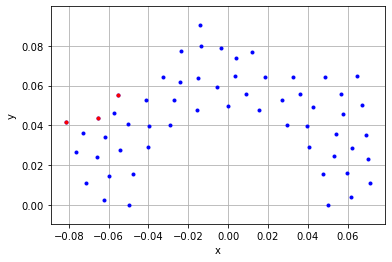

In [26]:
newU = FEM1(el_nod1,Coord_nod1,D,eff,Num_nod1,Num_el1,new_lim1)


In [33]:

for i in range(40):
    finalU[i]=newU[i]+finalU[i]

In [ ]:
for i in range(np.shape(newU)):
    for j in range(np.shape)

27.719789273447685


(-0.55, 0.55, -0.025, 0.525)

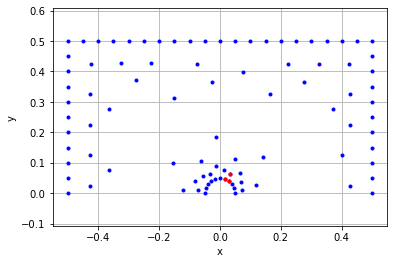

In [34]:
max_sig = 0
max_sig_i = -1
m_s=0
m_s_i=-1

for i in range(Num_el):
    B = make_B(i,el_nod,Coord_nod,D,eff,lim)
    Ui = np.zeros((6))
    Ui[0] = finalU[el_nod[i,0]*2]
    Ui[1] = finalU[el_nod[i,0]*2+1]
    Ui[2] = finalU[el_nod[i,1]*2]
    Ui[3] = finalU[el_nod[i,1]*2+1]  
    Ui[4] = finalU[el_nod[i,2]*2]
    Ui[5] = finalU[el_nod[i,2]*2+1] 
        #деформации (эпсилон)    
    Eps = B.dot(Ui)
    
        # напряжения(сигма)
    Nap = D.dot(Eps) 
     
    NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]])
        
    Sig,s = np.linalg.eig(NapM) 
        
    now_sig = m.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
    if now_sig > max_sig: #and now_sig < 10**10:
        max_sig = now_sig
        max_sig_i = i
        
        #now_sig = max(abs(Sig))
        #if n_s > m_s:
         #   m_s = n_s
          #  m_s_i = i
        #print('Модуль максимального главного напряжения ',max(abs(Sig)))
        #print('Деформации в ',i,' элементе',Eps)
        #print('Напряжения в ',i,' элементе',Nap)
print(max_sig)
a = Coord_nod[el_nod[max_sig_i,0],:]
b = Coord_nod[el_nod[max_sig_i,1],:]
c = Coord_nod[el_nod[max_sig_i,2],:]
for i in range(len(Coord_nod)):

    if Coord_nod[i,1]>=0: plt.plot(Coord_nod[i,0],Coord_nod[i,1],'b.')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

plt.plot(b[0,0],b[0,1],'r.')
plt.plot(a[0,0],a[0,1],'r.')
plt.plot(c[0,0],c[0,1],'r.')
plt.axis('equal')

28.951272710388775


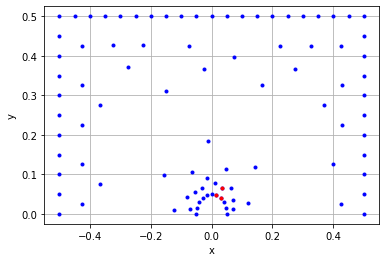

In [35]:
max_sig = -100
for i in range(len(oldnap)):
    NapM = np.matrix([[oldnap[i,0],oldnap[i,2]],[oldnap[i,2],oldnap[i,1]]])
    Sig,s = np.linalg.eig(NapM) 
        
    now_sig = m.sqrt(oldnap[i,0]**2-oldnap[i,0]*oldnap[i,1]+oldnap[i,1]**2+3*oldnap[i,2]**2)
    if now_sig > max_sig:
        max_sig = now_sig
        max_sig_i = i
print(max_sig)
a = Coord_nod[el_nod[max_sig_i,0],:]
b = Coord_nod[el_nod[max_sig_i,1],:]
c = Coord_nod[el_nod[max_sig_i,2],:]

for i in range(len(Coord_nod)):

    if Coord_nod[i,1]>=0: plt.plot(Coord_nod[i,0],Coord_nod[i,1],'b.')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(b[0,0],b[0,1],'r.')
plt.plot(a[0,0],a[0,1],'r.')
plt.plot(c[0,0],c[0,1],'r.')

In [110]:
A = np.ones((3,3))
b = np.array([[1,0,0]]).T
d(A,b)

array([[1.],
       [1.],
       [1.]])

In [88]:
31.0367574795/32.654959022996


0.9504454578443523

In [68]:
32.6549590229962-31.0367574795


1.6182015434962018